In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy import stats
%matplotlib inline

### True data
true_mu = 100
true_s2 = 20
var_vals = [
    stats.norm.rvs(
        loc=true_mu, 
        scale=np.sqrt(true_s2),
        size=np.random.randint(1, 10)
    ) for i in range(4)]

In [2]:
N = 10  # pocet vnitrnich iteraci
m = 20
s2 = 2000
a = 20
b = 100

# init \Xi^{\mu_i}
hyp_mu = np.array([
    m / s2, 
    -1 / (2 * s2)
])

# init \Xi^{\sigma^2_i}
hyp_sigma2 = np.array([-b, -a-1], dtype=float)

log = []

In [3]:
def expect_sigma2(hyp_sigma2):
    """Expected value for inverse gamma"""
    b = -hyp_sigma2[0]
    a = -hyp_sigma2[1] - 1
    # vezmu odhad E[sigma2] z invgama
    E_sigma2 = b / (a-1)
    return E_sigma2

def expect_mu(hyp_mu):
    """Expected value for \mu is equal to priot \mu"""
    s2 = -1 / (2 * hyp_mu[1])
    m = hyp_mu[0] * s2
    return [m, m**2 + s2]

In [4]:
seen_zs = np.array([])
for z_k in var_vals:
    seen_zs = np.append(seen_zs, z_k)
    
    # uvnitř iterací vždy používat estimate z předchozího z_k batche 
    hyp_mu_prev = hyp_mu
    hyp_sigma2_prev = hyp_sigma2
    
    for it in range(N):
        # vezmu odhad E[sigma2] z invgama
        E_sigma2 = expect_sigma2(hyp_sigma2)
        #  a pošlu ho do hustoty DAT, 
        # konkrétně ho dosadím do rce 14 za sigma2. 
        # Tím dostanu tu druhou matici se suf. stat.
        suff_mu = np.array([
            sum(seen_zs) / E_sigma2,
            -len(seen_zs) / (2 * E_sigma2)
        ])
        # Tuto matici vezmu a pošlu do normálního rozdělení, 
        # kde ho přičtu k tomu \Xi^{\mu_i}.
        hyp_mu = hyp_mu_prev + suff_mu
        # ...Tím dostanu nové hyperparametry m a s2,...
        # ... což mi dá nový odhad E[\mu] a E[\mu^2]
        E_mu, E_mu2 = expect_mu(hyp_mu)
        
        #Ty vezmu a pošlu do hustoty DAT, konkrétně 
        # dosadím do druhé matice v rci 15. 
        # Tím dostanu opět suf. stat. pro přiroz. parametr [1/sigma2, log sigma2]. 
        suff_sigma2 = np.array([
            -0.5 * ((seen_zs**2).sum() - (2*seen_zs*E_mu).sum() + seen_zs.size*E_mu2), #np.sum((seen_zs - E_mu) ** 2),
            -0.5 * len(seen_zs)
        ])
                
        # Tuto suf. stat pošlu do invgama, kde ho přičtu k tomu \Xi^{\sigma2}
        hyp_sigma2 = hyp_sigma2_prev + suff_sigma2
        
        # Tím dostanu updatované hyperparametry invgama rozdělení 
        # a pokračuji od kroku 2 novou iterací
        log.append([E_mu, E_sigma2])
    
print('True [m, sigma^2]\t', true_mu, true_s2)
print('Estimated [m, sigma^2]\t', round(E_mu, 2), round(E_sigma2, 2))

True [m, sigma^2]	 100 20
Estimated [m, sigma^2]	 99.6 27.23


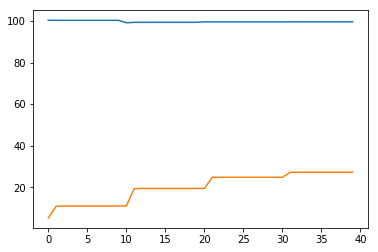

In [5]:
plt.plot(log)